In [45]:
import skimage.transform as transform
from skimage import img_as_ubyte
import tifffile as tif

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras import backend as K
import keras
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
import pandas as pd
from keras.backend import binary_crossentropy

import datetime
import random
import threading
import argparse

from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
K.set_image_dim_ordering('tf')

from __future__ import division
import os

os.system('export LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64')

os.environ['KERAS_BACKEND']='tensorflow'

os.environ['PATH']='/usr/local/cuda-8.0/bin'
os.environ['LD_LIBRARY_PATH']='/usr/local/cuda-8.0/lib64'

import numpy as np
from keras.models import load_model

img_rows = 1024
img_cols = 1024
num_channels = 3

smooth = 1e-12
num_mask_channels = 1

##############################################################
# best weights:
# ../checkpoints/0Building/weights.182-0.49.hdf5
# ../checkpoints/1Tree/weights.160-0.78.hdf5
#

def arg_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument('--category', type=int, default=1,
                        help='Choose the segmentation category')
    parser.add_argument('--resume', type=int, default=0,
                        help='resume the weights or not')
    parser.add_argument('--weight_path', type=str, default="../checkpoints/0Building/weights.182-0.49.hdf5",
                        help='weights path to resume')
    parser.add_argument('--lr', type=float, default=1e-3,
                        help='learning rate for the model')

    return parser.parse_args()

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)


def get_unet0():
    inputs = Input((img_rows, img_cols, num_channels))
    conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(inputs)
    conv1 = BatchNormalization(mode=0)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv1)
    conv1 = BatchNormalization(mode=0)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    pool1 = MaxPooling2D(dim_ordering='tf', pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(pool1)
    conv2 = BatchNormalization(mode=0)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)
    conv2 = Convolution2D(64, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv2)
    conv2 = BatchNormalization(mode=0)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)
    pool2 = MaxPooling2D(dim_ordering='tf', pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(pool2)
    conv3 = BatchNormalization(mode=0)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    conv3 = Convolution2D(128, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv3)
    conv3 = BatchNormalization(mode=0)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    pool3 = MaxPooling2D(dim_ordering='tf', pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(pool3)
    conv4 = BatchNormalization(mode=0)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    conv4 = Convolution2D(256, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv4)
    conv4 = BatchNormalization(mode=0)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    pool4 = MaxPooling2D(dim_ordering='tf', pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(pool4)
    conv5 = BatchNormalization(mode=0)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)
    conv5 = Convolution2D(512, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv5)
    conv5 = BatchNormalization(mode=0)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)

    up6 = merge([UpSampling2D(dim_ordering='tf', size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(up6)
    conv6 = BatchNormalization(mode=0)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)
    conv6 = Convolution2D(256, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv6)
    conv6 = BatchNormalization(mode=0)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)

    up7 = merge([UpSampling2D(dim_ordering='tf', size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(up7)
    conv7 = BatchNormalization(mode=0)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)
    conv7 = Convolution2D(128, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv7)
    conv7 = BatchNormalization(mode=0)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)

    up8 = merge([UpSampling2D(dim_ordering='tf', size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(up8)
    conv8 = BatchNormalization(mode=0)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)
    conv8 = Convolution2D(64, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv8)
    conv8 = BatchNormalization(mode=0)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)

    up9 = merge([UpSampling2D(dim_ordering='tf', size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(up9)
    conv9 = BatchNormalization(mode=0)(conv9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)
    conv9 = Convolution2D(32, 3, 3, border_mode='same', init='he_uniform', dim_ordering='tf')(conv9)
    crop9 = Cropping2D(cropping=((12, 12), (12, 12)), dim_ordering='tf')(conv9)
    conv9 = BatchNormalization(mode=0)(crop9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)
    conv10 = Convolution2D(num_mask_channels, 1, 1, activation='sigmoid', dim_ordering='tf')(conv9)

    model = Model(input=inputs, output=conv10)

    return model


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def form_batch(X, y, batch_size):
    X_batch = np.zeros((batch_size, num_channels, img_rows, img_cols))
    y_batch = np.zeros((batch_size, num_mask_channels, img_rows, img_cols))
    X_height = X.shape[2]
    X_width = X.shape[3]

    for i in range(batch_size):
        random_width = random.randint(0, X_width - img_cols - 1)
        random_height = random.randint(0, X_height - img_rows - 1)

        random_image = random.randint(0, X.shape[0] - 1)

        y_batch[i] = y[random_image, :, random_height: random_height + img_rows, random_width: random_width + img_cols]
        X_batch[i] = np.array(X[random_image, :, random_height: random_height + img_rows, random_width: random_width + img_cols])
    return X_batch, y_batch


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


@threadsafe_generator
def batch_generator(root, index, RGB, batch_size=32, horizontal_flip=True, vertical_flip=True, swap_axis=True, rotate=True):
    """ Batch generator for train, validation and test

    :param root: data directory name
    :param index: index of data
    :param RGB: RGB for pixel of the mask category
    :param batch_size: batch size
    :return: yield every image batch and mask batch
    """
    length = len(index)
    while True:
        for i in range(batch_size, length, batch_size):
            img_batch, mask_batch = [], []
            for idx in range(i - batch_size, i):
                img_path = os.path.join(root, '%d.tif' % idx)
                gt_path = os.path.join(root, '%d_mask.tif' % idx)

                img = tif.imread(img_path).astype(np.float32)
                for c in range(3):
                    img[:,:,c] = (img[:,:,c] - img[:,:,c].min()) / (img[:,:,c].max() - img[:,:,c].min()) # normalization

                gt = img_as_ubyte(tif.imread(gt_path))*255  # with regard to image process
                gt = _convert_mask(gt, RGB)

                if horizontal_flip:
                    if np.random.random() < 0.5:
                        img = flip_axis(img, 0)
                        gt = flip_axis(gt, 0)

                if vertical_flip:
                    if np.random.random() < 0.5:
                        img = flip_axis(img, 1)
                        gt = flip_axis(gt, 1)

                if swap_axis:
                    if np.random.random() < 0.5:
                        img = img.swapaxes(0, 1)
                        gt = gt.swapaxes(0, 1)

                if rotate:
                    if np.random.random() < 0.5:
                        img = transform.rotate(img, 90)
                        gt = transform.rotate(gt, 90)

                img_batch.append(img)
                mask_batch.append(gt)

            yield (np.array(img_batch), np.array(mask_batch))


def _convert_mask(img, RGB):
    R, G, B = RGB
    img = (img[..., 0] == R) & (img[..., 1] == G) & (img[..., 2] == B)
    img = img[..., np.newaxis].astype(np.float32)[12:1012, 12:1012, :]
    return img


def save_model(model, cross):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    json_name = 'architecture_' + cross + '.json'
    weight_name = 'model_weights_' + cross + '.h5'
    open(os.path.join('cache', json_name), 'w').write(json_string)
    model.save_weights(os.path.join('cache', weight_name), overwrite=True)


def save_history(history, suffix):
    filename = 'history/history_' + suffix + '.csv'
    pd.DataFrame(history.history).to_csv(filename, index=False)


def read_model(cross=''):
    json_name = 'architecture_' + cross + '.json'
    weight_name = 'model_weights_' + cross + '.h5'
    model = model_from_json(open(os.path.join('../src/cache', json_name)).read())
    model.load_weights(os.path.join('../src/cache', weight_name))
    return model

def split_dataset(root):
    """ split the index of train, validation, test data by 8:1:1 randomly
        data: named from 0 to n as n.tif
        label: named from 0 to n as n_mask.tif

    :param root: the root path of the dataset
    :return: tuple of indices of (train, validation, test)
    """
    np.random.seed(55)
    length = int(len(os.listdir(root)) / 2)
    indices = np.random.permutation(length)
    return indices[:int(0.8*length)], \
           indices[int(0.8*length): int(0.9*length)], \
           indices[int(0.9*length):]

kaggle img:
(0.029411765, 0.99215686)
(1024, 1024, 4)
kaggle mask:
(0, 255)
((1000, 1000, 1), (1000, 1000, 3), 0.0, 1.0)
(0.0, 1.0)

orbita img:
(0.0, 1.0)
(1024, 1024, 3)
orbita mask:
(0, 255)
((1000, 1000, 1), (1000, 1000, 3), 0.0, 1.0)
(0.0, 1.0)


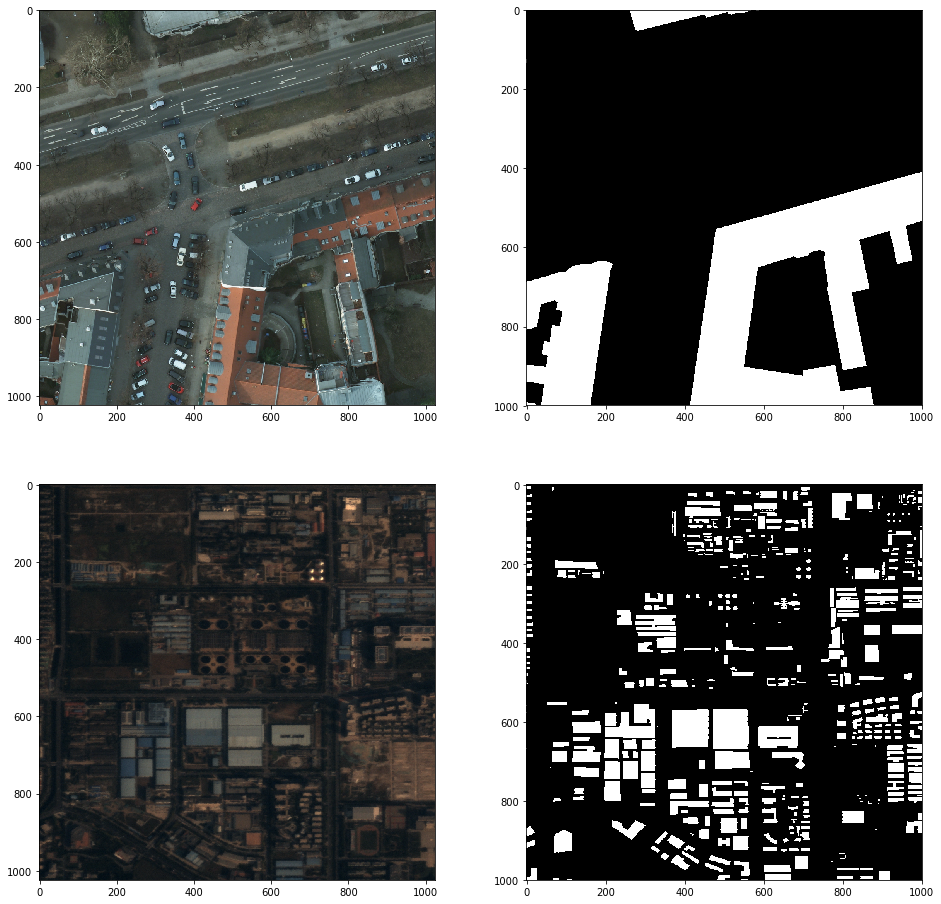

In [44]:
import matplotlib.pyplot as plt
#-----------------------kaggle-------------------------
img = tif.imread('../data/99.tif').astype(np.float32)
print('kaggle img:')
print(img.min(), img.max())
print img.shape

#mask = tif.imread('../data/99_mask.tif').astype(np.float32)
mask = img_as_ubyte(tif.imread('../data/99_mask.tif'))
print('kaggle mask:')
print(mask.min(), mask.max())
mask = _convert_mask(mask, [0,0,255])
newmask = np.zeros((mask.shape[0], mask.shape[1],3),dtype=mask.dtype)
print(mask.shape, newmask.shape, mask.min(), mask.max())
newmask[:,:,0] = mask[:,:,0]
newmask[:,:,1] = mask[:,:,0]
newmask[:,:,2] = mask[:,:,0]
print(newmask.min(), newmask.max())

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(img[..., :3])

plt.subplot(2, 2, 2)
plt.imshow(newmask[..., :3])


#----------------------orbita--------------------------
img = tif.imread('../data/VAZ1_201709291702_001_0023_L1A/data/99.tif').astype(np.float32)
for c in range(3):
    img[:,:,c] = (img[:,:,c] - img[:,:,c].min()) / (img[:,:,c].max() - img[:,:,c].min()) # normalization
print('\norbita img:')
print(img.min(), img.max())
print img.shape

mask = img_as_ubyte(tif.imread('../data/VAZ1_201709291702_001_0023_L1A/data/99_mask.tif'))*255
print('orbita mask:')
print(mask.min(), mask.max())
mask = _convert_mask(mask, [255,255,255])
newmask = np.zeros((mask.shape[0], mask.shape[1],3),dtype=mask.dtype)
print(mask.shape, newmask.shape, mask.min(), mask.max())
newmask[:,:,0] = mask[:,:,0]
newmask[:,:,1] = mask[:,:,0]
newmask[:,:,2] = mask[:,:,0]
print(newmask.min(), newmask.max())

plt.subplot(2, 2, 3)
plt.imshow(img[..., :3])

plt.subplot(2, 2, 4)
plt.imshow(newmask[..., :3])

In [46]:
now = datetime.datetime.now()
root = '../data/VAZ1_201709291702_001_0023_L1A/data'
mask_channel = 1
batch_size = 1
nb_epoch = 200
category = 0 # building
resume = 0
resume_path = ''

class_names = {
    0: "Building",
    1: "Tree",
    2: "Grass",
    3: "Unknown",
    4: "Car",
    5: "Road"
}

category_code = {
    0: [0, 0, 255],
    1: [0, 255, 0],
    2: [0, 255, 255],
    3: [255, 0, 0],
    4: [255, 255, 0],
    5: [255, 255, 255],
}

RGB = [255, 255, 255]#category_code[category]

train, validation, test = split_dataset(root)  # list: type - int 

print('[{}] Creating and compiling model...'.format(str(datetime.datetime.now())))

weight_path = "../checkpoints/%d%s/" % (category, class_names[category])
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
weight_path = os.path.join(weight_path, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
callbacks = [
    ModelCheckpoint(
        filepath=weight_path,
        monitor='val_loss',
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode='auto',
        period=1
    )
]

if resume:
    WEIGHT_PATH = resume_path
    model = load_model(
        WEIGHT_PATH,
        custom_objects={
            u'jaccard_coef_loss': jaccard_coef_loss,
            u'jaccard_coef_int': jaccard_coef_int
        })

else:
    model = get_unet0()

    model.compile(
        optimizer=Nadam(lr=1e-3),
        loss=jaccard_coef_loss,
        metrics=['binary_crossentropy', jaccard_coef_int, 'binary_accuracy']
    )

model.fit_generator(
    batch_generator(root, train, RGB, batch_size),
    validation_data=batch_generator(root, validation, RGB, batch_size),
    nb_epoch=nb_epoch,
    verbose=1,
    samples_per_epoch=int(len(train) / batch_size)*batch_size,
    nb_val_samples=int(len(validation) / batch_size)*batch_size,
    callbacks=callbacks,
    nb_worker=8
)

[2018-08-26 17:44:38.352001] Creating and compiling model...
Epoch 1/200
1748/1748 [==============================] - 781s - loss: 1.1207 - binary_crossentropy: 0.2746 - jaccard_coef_int: 0.5306 - binary_accuracy: 0.9013 - val_loss: 1.9372 - val_binary_crossentropy: 0.6315 - val_jaccard_coef_int: 0.3183 - val_binary_accuracy: 0.8236
Epoch 2/200
1748/1748 [==============================] - 780s - loss: 0.8041 - binary_crossentropy: 0.1968 - jaccard_coef_int: 0.6401 - binary_accuracy: 0.9335 - val_loss: 2.0740 - val_binary_crossentropy: 0.8502 - val_jaccard_coef_int: 0.3233 - val_binary_accuracy: 0.7061
Epoch 3/200
1748/1748 [==============================] - 776s - loss: 0.6586 - binary_crossentropy: 0.1573 - jaccard_coef_int: 0.7022 - binary_accuracy: 0.9476 - val_loss: 1.8475 - val_binary_crossentropy: 0.7305 - val_jaccard_coef_int: 0.3540 - val_binary_accuracy: 0.7798
Epoch 4/200
1748/1748 [==============================] - 775s - loss: 0.5524 - binary_crossentropy: 0.1290 - jaccard_

KeyboardInterrupt: 